#**Deep Learning with PyTorch**

## Table of Contents
1. 데이터 로딩
    + Dataset class, Transforms, DataLoader, Data visualization in PyTorch
2. 모델 정의하기
    + PyTorch를 사용하여 심층 신경망(DNN) 구축하기
3. Training and Evaluation
    + Loss 계산과 Backpropagation 실행을 통한 모델 업데이트
    + 학습된 모델의 성능 측정
4. 결과 그리기
5. Applications
    + 활성화 함수(activation function) 없이 선형 레이어(fully-connected layer) 만을 사용한 네트워크를 학습하고 이전 결과와 비교
    + 다른 optimizer method들(SGD with momentum, Adam과 같은)을 사용해보고 결과 확인하기
    + Overfitting 방지를 위한 Regularization 기술들
    + 더 복잡한 데이터 셋(CIFAR10)에서의 실험
    
6. Reference


## 1. 데이터 로딩(Data Loading)
- 사용하고자 하는 데이터 셋을 원할하게 로딩(loading) 시키기 위해서는, 먼저 PyTorch에서 제공하는 `Dataset Class`, `Transforms`, `DataLoader`에 친숙해져야 한다.



1) Dataset Class
- `Dataset Class` 는 데이터셋을 나타내는 추상클래스이다. 우리가 임의로 만드는 데이터셋은 `Dataset`을 상속하고 아래와 같이 오버라이드(override)해야 한다.
 - `len(dataset)` 에서 호출되는 `__len__`은 데이터셋의 크기를 리턴해야함.
 - `dataset[i]`에서 호출되는 `__getitem__`은 $i$번째 샘플을 찾는데 사용된다.

In [ ]:
#Examples of Dataset Class

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm import tqdm


class MyDataset(Dataset): #Inherit Dataset
    def __init__(self, input, label, transforms=None):
        self.input = input
        self.label = label
        self.transforms = transforms

    def __len__(self):
        return len(self.input)
    
    def __getitem__(self, idx):
        x = self.input[idx]
        y = self.label[idx]

        if self.transforms:
            x,y = self.transforms((x,y))

        return x, y

input = np.random.randn(5,3)
label = np.array([i for i in range(5)]).reshape(5,1)

dataset = MyDataset(input, label)
print('The size of dataset:', len(dataset))
print('1st data sample: ', dataset[0])
print('3rd data sample: ', dataset[2])


2) Transforms
- 우리가 사용하는 데이터셋의 이미지들은 각기 다른 크기를 가질 수도 있으며, 정규화(normalize) 시킬 필요가 있을 수도 있으며, PyTorch에서 모델에 들어가기 위해서는 tensor형으로 변환도 시켜줘야한다. 따라서 우리는 데이터셋의 샘플을 전처리(preprocessing) 시킬 필요가 있으며 이를위해 PyTorch에서 제공하는 기본 변환(transform) 방법들을 다음과 같이 소개한다:
 - `ToTensor` : numpy 이미지를 tensor 이미지로 변환 (Pytorch에서 네트워크에 입력을 집어넣으려면 tensor 변환은 필수적이다.)
 - `Resize`: 입력 PIL 이미지를 주어진 크기로 조정 (각 이미지 마다 크기가 다를때 사용)
 - `Normalize` : 주어진 평균 및 표준 편차로 텐서 이미지를 정규화
  - `RandomCrop` : 이미지를 랜덤적으로 잘라낸다. Data augmentation을 위해 사용된다.

In [ ]:
#Define Tranforms 

class ToTensor(object):
    def __call__(self, sample):
        input, label = sample
        return torch.from_numpy(input), torch.from_numpy(label)

In [ ]:
#The use of Transforms

dataset = MyDataset(input, label, ToTensor())
print('1st data sample : ', dataset[0])
print('3rd data sample : ', dataset[2])

**-그러나 PyTorch에서는 보편적 데이터셋(ImageNet, CIFAR10, MNIST 등의)을 위한 데이터 로더(Data Loader)와 데이터 변환(Data Transform)기능들을 편리하게 제공하는 torchvision이라는 패키지를 제공한다.**




그러면 이를 이용하여 오늘 강의에서 사용하게 될 MNIST 데이터셋을 로드해보자.

\* MNIST 데이터 세트는 0에서 9 사이의 손으로 쓴 한 자리 숫자의 28 * 28 pixel grayscale 이미지로 구성된 데이터 세트이다.

In [ ]:
from torchvision import datasets, transforms

torch.manual_seed(2020) # 시드를 고정

train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True) # The output of torchvision datasets are PILImage images of range [0,1]. We transforms them to Tensors of normalized range [-1,1] Using ToTensor()
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

다음과 같이 학습 및 테스트 데이터 세트의 크기를 확인할 수 있다.

In [ ]:
print('\nThe size of training dataset :', len(train_dataset))
print('\nThe size of test dataset :', len(test_dataset))

3) DataLoader

- 실제로 DNN을 학습시킬때는 한번의 update에 모든 데이터 샘플을 사용하는 batch gradient를 이용하는 대신 한번의 update에 batch 단위의 샘플이 사용되는 mini batch gradient를 이용하게 된다. 이를 위해 데이터를 batch 단위로 분리하고 셔플(Shuffle)해야하는데 이는 PyTorch의 `DataLoader`에 의해 수행된다.


In [ ]:
batch_size = 64 # Batch size 설정

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # Shuffle argument controls data shuffling for stochastic gradient descent
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)  # iter() 메소드는 iterable object를 반환한다. (즉, loop 문 사용이 가능하다)
inputs, labels = dataiter.next()

print(inputs.shape) #데이터 로더에 의해 한배치의 shape은 (배치사이즈, 채널 수, 높이, 폭)와 같이 된다.
print(labels.shape)

# 보통 아래와 같이 사용한다.
for (images, labels) in train_loader:
    #print(images.shape)
    #print(labels.shape)
    ####################
    #    statements  
    ####################
    break 

4) Data Visualization
- 우리는 입력 이미지를 시각화 할 수 있으며 다음과 같은 코드로 이를 구현할 수 있다.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

dataiter = iter(train_loader)
inputs, labels = dataiter.next()

figure = plt.figure()
plt.imshow(inputs[0].numpy().squeeze(), cmap='gray_r') # We can see a first image of a batch
plt.show()

In [ ]:
def image_show(input):
    input = input.numpy()
    plt.imshow(np.transpose(input, (1,2,0)).squeeze(), cmap='gray_r')
    plt.show()

image_show(torchvision.utils.make_grid(inputs)) # We can see all 64 images of a batch

## 2. Defining our Model

- 이번 실습에서는 Multi-classification Task를 진행해 볼것이며, 이를 위해 작은 MLP 모델(Fully-Connected Layers로만 구성된)을 구축 할 것이다. 
- 지난 시간에 배웠듯이, Fully-Connected Layer에서는 다음과 같은 선형 연산이 이루어진다.

 $\mathbf{Y} = \mathbf{X}\mathbf{W} + \mathbf{b}$ where $\mathbf{W} \in \mathbf{R}^{ \ previous\_layer\_size \times next\_layer\_size}$ and $\mathbf{b}$ $\in \mathbf{R}^{next\_layer\_size}$

- Fully-Connected layer를 통과하고 나면, 마지막 output layer를 제외하고 non-lineariry를 주기위해 activation function(e.g., ReLU)이 사용된다. 
 + ReLU(x) = max(0,x)

- Multi-class classification에서는 output layer에서 Softmax function이 사용된다.
 + $\tilde{y}_{i}$ = $[Softmax(x)]_i$ = $\frac{e^{x_i}}{\sum_{j=1}^{C}e^{x_k}}$ where $x = [x_1, x_2, \ldots, x_C]$ 이며 C는 class의 개수이다.


그러면, 다음과 같이 3 개의 Fully-Connected 레이어로 구성된 MLP 모델을 만들어 보자.

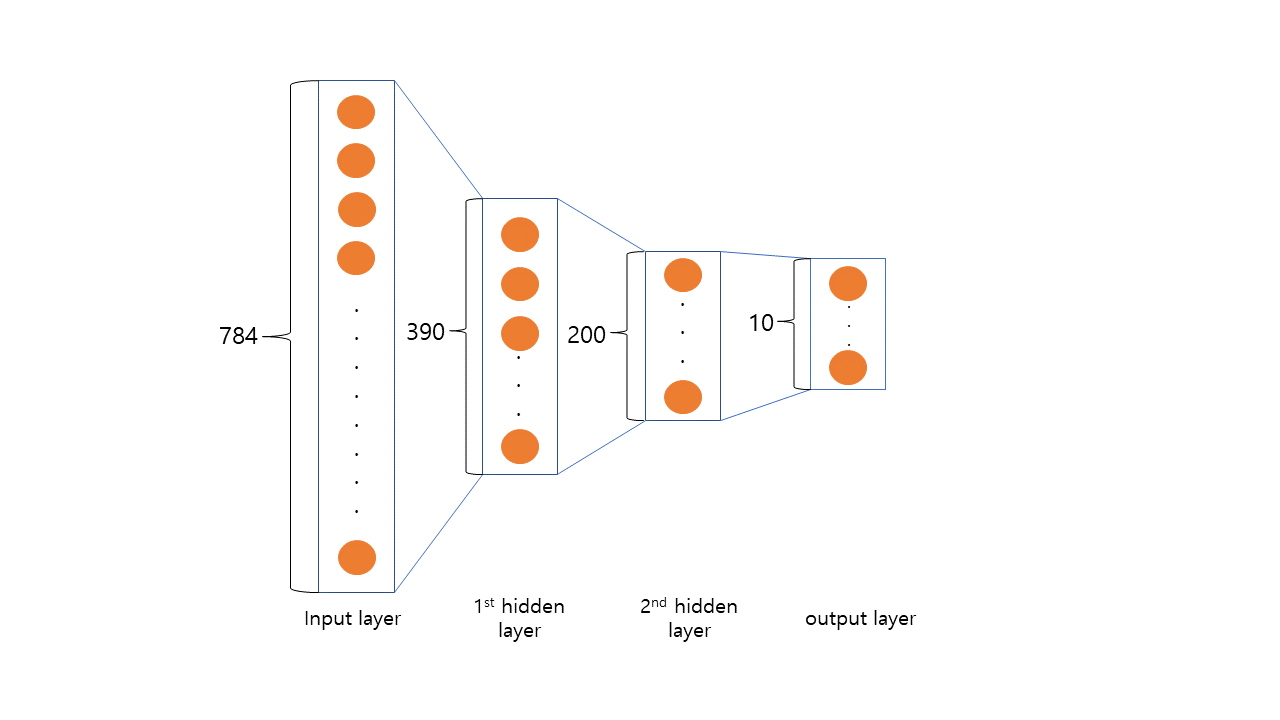

In [ ]:
class Mynetwork(nn.Module):

    def __init__(self):

        super(Mynetwork, self).__init__()
        # torch.nn.Linear(size of each input sample, size of each output sample)
        self.fc1 = nn.Linear(784, 390) # Input size는 784 (28*28*1), output size는 첫번째 hidden layer의 크기로 설정 되야 한다.
        self.fc2 = nn.Linear(390, 200) # Input size는 첫번째 hidden layer의 크기로, output size는 두번째 hidden layer의 크기로 설정 되야 한다.
        self.fc3 = nn.Linear(200, 10) # Input size는 두번째 hidden layer의 크기로, output size는 10(클래스의 개수)로 설정 되야 한다. 
        
    def forward(self, x):

        x = x.view(-1, 1*28*28) # Fully-connected layer에 넣기 위해 Shape을 ([batch_size, channels, row, col]) 에서 [batch_size, channels*row*col] 로 바꾼다.
        x = F.relu(self.fc1(x)) # Fully-connected layer를 통과시키고 Relu function(Activation function)을 통과 시킨다.
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Softmax function is not applied here.

        return x

Then, let's check our model.

In [ ]:
model = Mynetwork()
input_test = torch.randn(64,1,28,28)  # shape: (배치사이즈, 채널 수, 높이, 폭)
output = model(input_test)  # output shape: (배치사이즈, 아웃풋 뉴런 수)
print(output.size())

## 3. Training and Evaluation
Training : 데이터를 로딩이 완료되고 사용할 모델을 정의 하였다면, 이를 이용하여 딥 뉴럴 네트워크를 학습 시킬 수 있다.
- Training에 필요한 파라미터를 설정한 후,
- 1) 입력 값을 모델에 통과시켜 output을 얻고 
- 2) 이러한 output과 실제 label을 비교하여 loss를 계산한다.
- 3) Backpropagation을 실행하여 그래디언트 값을 계산한다.
- 4) 계산된 그래디언트를 이용하여 모델을 업데이트한다.

Evaluation : Training 종료 후 얻은 모델을 사용하여 입력에 대한 예측을 수행하고 Evaluation metrics(예를 들면, accuracy와 같은)을 계산하여 우리가 얻은 모델의 성능을 측정 할 수 있습니다.



In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import torch.optim as optim

from tqdm import tqdm

################## 데이터 로드/ 모델 구축 ##################

# MNIST 데이터셋 로드

##################################################

###################################################

batch_size = 64 # Batch size 설정

#train loader와 test loader 만들기

##################################################

###################################################



device = 'cuda' if torch.cuda.is_available() else 'cpu' #GPU 사용이 가능하면 cuda 반환

#위에서 정의한 모델로 만들기
model1 = Mynetwork()
model1.to(device) # GPU 사용이 가능하면 model을 GPU로 옮긴다.

################## Training을 위한 변수 설정 ##################

# Epoch 설정
num_epoch = 15

# 우리가 하려는 Task에 부합하는 Loss의 종류를 결정
criterion = nn.CrossEntropyLoss()

#사용할 optimizer의 종류를 선택하고 learning rate 설정
optimizer = optim.SGD(model1.parameters(), lr=0.001)

In [ ]:
################## Training ##################

def train(model, device, train_loader, optimizer, criterion):

    model.train() # training mode 
    # dropout이나 batch-normalization을 사용하는 모델의 레이어는 현재 모드(training 또는 evaluation)에 따라 다르게 동작해야한다.
    
    losses_batch = []

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) # GPU사용이 가능하면 data를 GPU로 옮긴다.
        optimizer.zero_grad() # Optimizer의 gradient를 초기화 한다.
         # 1) forward pass를 진행한다.
         # 2) 예측 output과 실제 label을 비교하여 loss를 계산한다
        losses_batch.append(loss)
         # 3) Backpropagation을 실행하여 그래디언트 값을 계산한다.
         # 4) 계산된 그래디언트를 이용하여 모델을 업데이트한다.

    loss_epoch = sum(losses_batch)/len(losses_batch)

    return loss_epoch

In [ ]:
################## Evaluation ##################

def eval(model, device, test_loader):
     
    model.eval() # evaluation mode
    total = 0
    correct = 0

    with torch.no_grad(): # Test 때에는 gradient값이 필요하지 않으므로 연산 추적을 멈춘다.
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs) 
            _, predicts = torch.max(outputs.data , 1) # 예측 label 생성 
            total += labels.size(0)
            correct += (predicts==labels).sum().item() # 예측 label과 실제 label을 비교하여 accuracy 측정
    
    Accuracy = 100*correct/total

    print('Test Accuracy: {:.2f}%'.format(Accuracy))
    return Accuracy

In [ ]:
# Implement training and evaluation

train_loss_epoch = []
test_acc_epoch = []

for epoch in tqdm(range(num_epoch)):
    train_loss_epoch.append(train(model1, device, train_loader, optimizer, criterion)) 
    test_acc_epoch.append(eval(model1, device, test_loader))

## 4. 결과 그리기
 - matplotlib 라이브러리를 사용하여 위에서 얻은 결과를 그릴 수 있다.

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10,10))

f1 = figure.add_subplot(221)
f2 = figure.add_subplot(222)

epochs = range(num_epoch)

f1.plot(epochs, train_loss_epoch)
f1.set_title('Training loss over epoch')
f1.set_xlabel('Epoch')
f1.set_ylabel('Training Loss')


f2.plot(epochs, test_acc_epoch)
f2.set_title('Test Accuracy over epoch')
f2.set_xlabel('Epoch')
f2.set_ylabel('Test Accuracy')

plt.show()

## 5. Applications

### 1) 활성화 함수(activation function) 없이 선형 레이어(fully-connected layer) 만을 사용한 네트워크의 학습 및 이전 결과와의 비교
    

In [ ]:
class Only_Linear_Model(nn.Module):

    def __init__(self):

        super(Only_Linear_Model, self).__init__()
        # torch.nn.Linear(size of each input sample, size of each output sample)
        self.fc1 = nn.Linear(784,390) 
        self.fc2 = nn.Linear(390, 200) 
        self.fc3 = nn.Linear(200, 10) 
        
    def forward(self, x):

        x = x.view(-1, 1*28*28) 
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model2 = Only_Linear_Model()
model2.to(device)

num_epoch = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.001)


train_loss_epoch_Linear = []
test_acc_epoch_Linear = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_Linear.append(train(model2, device, train_loader, optimizer, criterion))
    test_acc_epoch_Linear.append(eval(model2, device, test_loader))

In [ ]:
figure = plt.figure(figsize=(10,10))

f1 = figure.add_subplot(221)
f2 = figure.add_subplot(222)

epochs = range(num_epoch)

f1.plot(epochs, train_loss_epoch[:15], label='Non-Linear Model')
f1.plot(epochs, train_loss_epoch_Linear, label='Linear Model')
f1.legend()
f1.set_title('Training loss over epoch')
f1.set_xlabel('Epoch')
f1.set_ylabel('Training Loss')

f2.plot(epochs, test_acc_epoch[:15],  label='Non-Linear Model')
f2.plot(epochs, test_acc_epoch_Linear,  label='Linear Model')
f2.legend()
f2.set_title('Test Accuracy loss over epoch')
f2.set_xlabel('Epoch')
f2.set_ylabel('Test Accuracy')

plt.show()

### 2) 다른 optimizer method들(SGD with momentum, Adam과 같은)의 사용 및 결과 확인



In [ ]:
#SGD with momentum

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_momentum = Mynetwork()
model_momentum.to(device)

num_epoch = 15


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_momentum.parameters(), lr=0.001, momentum=0.9)


train_loss_epoch_momentum = []
test_acc_epoch_momentum = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_momentum.append(train(model_momentum, device, train_loader, optimizer, criterion))
    test_acc_epoch_momentum.append(eval(model_momentum, device, test_loader))

In [ ]:
#Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_Adam = Mynetwork()
model_Adam.to(device)

num_epoch = 15



criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Adam.parameters(), lr=0.001, betas=(0.9,0.999))


train_loss_epoch_Adam = []
test_acc_epoch_Adam = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_Adam.append(train(model_Adam, device, train_loader, optimizer, criterion))
    test_acc_epoch_Adam.append(eval(model_Adam, device, test_loader))

In [ ]:
figure = plt.figure(figsize=(10,10))

f1 = figure.add_subplot(221)
f2 = figure.add_subplot(222)

epochs = range(num_epoch)

f1.plot(epochs, train_loss_epoch[:15], label='SGD')
f1.plot(epochs, train_loss_epoch_momentum, label='SGD with momentum')
f1.plot(epochs, train_loss_epoch_Adam, label='Adam')
f1.legend()
f1.set_title('Training loss over epoch')
f1.set_xlabel('Epoch')
f1.set_ylabel('Training Loss')

f2.plot(epochs, test_acc_epoch[:15],  label='SGD ')
f2.plot(epochs, test_acc_epoch_momentum,  label='SGD with momentum')
f2.plot(epochs, test_acc_epoch_Adam,  label='Adam')
f2.legend()
f2.set_title('Test Accuracy loss over epoch')
f2.set_xlabel('Epoch')
f2.set_ylabel('Test Accuracy')

plt.show()

### 3) Overfitting 방지를 위한 Regularization 기술들


#### 1.Weight Decay - L2 (Ridge) regularization

In [ ]:
#L2 (Ridge) regularization

model_L2 = Mynetwork()
model_L2.to(device)

num_epoch = 15

device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_L2.parameters(), lr=0.001, weight_decay=0.05) # weight decay parameter(lambda)에 값을 넣어 줌으로써 L2 regularization 효과를 준다.


train_loss_epoch_L2 = []
test_acc_epoch_L2 = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_L2.append(train(model_L2, device, train_loader, optimizer, criterion))
    test_acc_epoch_L2.append(eval(model_L2, device, test_loader))

#### 2.Dropout

In [ ]:
#Dropout

class Mynetwork_dropout(nn.Module):

    def __init__(self):

        super(Mynetwork_dropout, self).__init__()
        self.fc1 = nn.Linear(784,390) 
        self.fc2 = nn.Linear(390, 200) 
        self.fc3 = nn.Linear(200, 10) 
        self.dropout = nn.Dropout(p=0.2) # training 중에는 p의 확률로 입력 텐서의 일부 요소를 무작위로 0으로 만든다.


    def forward(self, x):

        x = x.view(-1, 1*28*28)
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) 

        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_dropout = Mynetwork_dropout()
model_dropout.to(device)

num_epoch = 15



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=0.001)


train_loss_epoch_DO = []
test_acc_epoch_DO = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_DO.append(train(model_dropout, device, train_loader, optimizer, criterion))
    test_acc_epoch_DO.append(eval(model_dropout, device, test_loader))

In [ ]:
figure = plt.figure(figsize=(10,10))

f1 = figure.add_subplot(221)
f2 = figure.add_subplot(222)

epochs = range(num_epoch)

f1.plot(epochs, train_loss_epoch_L2, label='SGD with L2 regularization')
f1.plot(epochs, train_loss_epoch_DO, label='SGD with Dropout')

f1.legend()
f1.set_title('Training loss over epoch')
f1.set_xlabel('Epoch')
f1.set_ylabel('Training Loss')

f2.plot(epochs, test_acc_epoch_L2,  label='SGD with L2 regularization')
f2.plot(epochs, test_acc_epoch_DO,  label='SGD with Dropout')

f2.legend()
f2.set_title('Test Accuracy loss over epoch')
f2.set_xlabel('Epoch')
f2.set_ylabel('Test Accuracy')

plt.show()

### 4) 더 복잡한 데이터 셋(CIFAR10)에서의 실험
 - CIFAR10 dataset은 60000개 (50000개는 Training dataset, 10000개는 test dataset)의 32*32 pixel 컬러이미지들로 구성되어 있다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

#Data loading
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(), # 주어진 확률로 주어진 이미지를 무작위로 수평 뒤집는다. (Defualt는 0.5) # Data augementation을 위해 사용된다.
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2) #num_workers는 데이터 로딩을 위해 몇개의 CPU 코어를 사용할 것인지를 결정.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=2 )  # 코어를 많이 할당할수록 데이터 로딩은 빨라지지만 다른 부가적인 처리에 딜레이가 생기므로 적절한 밸런스를 유지 하는 것이 필요.

#Define model
class model_cifar(nn.Module):
    def __init__(self):
        super(model_cifar, self).__init__()
         # input size가 (3*32*32)이고 output size가 1024인 linear layer 만들기
         # input size가 1024이고 output size가 512인 linear layer 만들기
         # input size가 512이고 output size가 128인 linear layer 만들기
         # input size가 128이고 output size가 10인 linear layer 만들기

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        return out


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model_cifar()
model.to(device) #Move model to gpu

#Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


#Training and Evaluation
num_epoch = 15

train_loss_epoch_cifar = []
test_acc_epoch_cifar = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_cifar.append(train(model, device, train_loader, optimizer, criterion))
    test_acc_epoch_cifar.append(eval(model, device, test_loader))



#Plot the results
figure = plt.figure(figsize=(10,10))

f1 = figure.add_subplot(221)
f2 = figure.add_subplot(222)

epochs = range(num_epoch)

f1.plot(epochs, train_loss_epoch_cifar, label='SGD with momentum')

f1.legend()
f1.set_title('Training loss over epoch on CIFAR10')
f1.set_xlabel('Epoch')
f1.set_ylabel('Training Loss')

f2.plot(epochs, test_acc_epoch_cifar,  label='SGD with momentum')

f2.legend()
f2.set_title('Test Accuracy loss over epoch on CIFAR10')
f2.set_xlabel('Epoch')
f2.set_ylabel('Test Accuracy')

plt.show()


## 6. Reference
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html?highlight=dataset%20dataloader

https://wikidocs.net/57165

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/